In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
import time
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

C:\Users\CampusUser\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=pd.read_csv('Hotel_Reviews.csv')

In [3]:
# Correct day of the review into integer
df['days_since_review']=pd.to_numeric(df['days_since_review'].str.replace(r'[a-z]+', ""))

In [4]:
# Lets isolate the reviews that have some information into negative/positive
# To keep it simple, lets start getting the badly scored and highly scored reviews to feed later on to the classifier.
# DataFrames with Negative reviews and positive reviews given
neg_rev=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)
pos_rev=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)
neg_rev = neg_rev[neg_rev['Reviewer_Score']<5].reset_index().drop('index',1)
pos_rev = pos_rev[pos_rev['Reviewer_Score']>8].reset_index().drop('index',1)

In [5]:
# To run this whole 515k database run faster, TokTok is used
from nltk.tokenize import ToktokTokenizer
toktok = ToktokTokenizer()


In [6]:
# Stopwords, numbers and punctuation to remove
remove_punct_and_digits = dict([(ord(punct), ' ') for punct in string.punctuation + string.digits])
stopWords = set(stopwords.words('english'))
def word_cleaner(data):
    cleaned_word = data.lower().translate(remove_punct_and_digits)
    words = word_tokenize(cleaned_word)
    words = [toktok.tokenize(sent) for sent in sent_tokenize(cleaned_word)]
    wordsFiltered = []
    if not words:
        pass
    else:
        for w in words[0]:
            if w not in stopWords:
                wordsFiltered.append(w)
                end=time.time()
    return wordsFiltered


In [7]:
# We take a small sample within our database to speed up Learning
neg_red=neg_rev[:50000].copy()
pos_red=pos_rev[:50000].copy()

In [8]:
# Now, we create a set related to positive and negative review
def word_feats(words):
    return dict([(word, True) for word in words])
neg_set=[(word_feats(word_feats(word_cleaner(neg_red.loc[i,'Negative_Review']))), 0) for i in range(len(neg_red))]
pos_set=[(word_feats(word_feats(word_cleaner(pos_red.loc[i,'Positive_Review']))), 1) for i in range(len(pos_red))]


In [9]:
# We train the model and use CV to test accuracy

negcutoff = int(len(neg_set)*3/4)
poscutoff = int(len(pos_set)*3/4)
 
trainfeats = neg_set[:negcutoff] + pos_set[:poscutoff]
testfeats = neg_set[negcutoff:] + pos_set[poscutoff:]
print(len(trainfeats), len(testfeats))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print( 'accuracy:', nltk.classify.util.accuracy(classifier, testfeats))

53724 17908
accuracy: 0.8930645521554612


In [10]:
# Now to get the overview of the most hated/loved words so...
# We build the dataframe of words with respective sentiment and score

cpdist = classifier._feature_probdist
word=[]
score=[]
sentiment=[]
for (fname, fval) in classifier.most_informative_features(100):
            def labelprob(l):
                return cpdist[l, fname].prob(fval)

            labels = sorted([l for l in classifier._labels
                             if fval in cpdist[l, fname].samples()],
                            key=labelprob)
            if len(labels) == 1:
                continue
            l0 = labels[0]
            l1 = labels[-1]
            if cpdist[l0, fname].prob(fval) == 0:
                ratio = 'INF'
            else:
                ratio = '%8.1f' % (cpdist[l1, fname].prob(fval) /
                                   cpdist[l0, fname].prob(fval))
            sentiment.append(int(l1))
            word.append(fname)
            score.append(float(ratio))

In [11]:
# Dividing the scores into negative and positive
word_scores=pd.DataFrame({'word':word,'sentiment':sentiment,'score':score})
neg_word_scores=word_scores[word_scores.sentiment==0]
pos_word_scores=word_scores[word_scores.sentiment==1]
display(word_scores[word_scores['sentiment']==1].head())
display(word_scores[word_scores['sentiment']==0].head())
neg_given=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)
pos_given=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)

,word,sentiment,score
7,superb,1,198.0
20,delicious,1,127.1
47,excellent,1,77.8
54,fab,1,72.0
56,beautifully,1,70.8


,word,sentiment,score
0,worst,0,929.9
1,rude,0,691.1
2,dirty,0,648.6
3,disgusting,0,361.3
4,terrible,0,302.3


In [12]:
# We create two new columns, one that will give a positive and one a negative score
# Sums positive and negative scores for a given review
def pos_sentiment_sum(review):
    pos=0
    asd=word_cleaner(review)
    set_w=set(pos_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            pos+=pos_word_scores[pos_word_scores['word']==word].score.iloc[0]
    
    return pos

def neg_sentiment_sum(review):
    neg=0
    asd=word_cleaner(review)
    set_w=set(neg_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            neg+=neg_word_scores[neg_word_scores['word']==word].score.iloc[0]
    
    return neg

In [13]:
# Produce the pos and neg colums in database
pos_col=[]
for i in range(len(df)):
    if df.Positive_Review[i]=='No Positive':
        pos_col.append(int(0))
    else:
        pos_col.append(pos_sentiment_sum(df.Positive_Review[i]))
df['pos_score']=pos_col

neg_col=[]
for i in range(len(df)):
    if df.Negative_Review[i]=='No Negative':
        neg_col.append(int(0))
    else:
        neg_col.append(neg_sentiment_sum(df.Negative_Review[i]))
df['neg_score']=neg_col

In [14]:
# Reviews grouped by rate band
score_9=df[df.Reviewer_Score>9].copy()
score_4=df[df.Reviewer_Score<4].copy()
score_6=df[df.Reviewer_Score<7].copy()
score_7=df[(df.Reviewer_Score>7)&(df.Reviewer_Score<8)].copy()
score_8=df[(df.Reviewer_Score>8)&(df.Reviewer_Score<9)].copy()
print(score_6.shape)
print(score_7.shape)
print(score_8.shape)
print(score_9.shape)

(86851, 19)
(92830, 19)
(88104, 19)
(246390, 19)


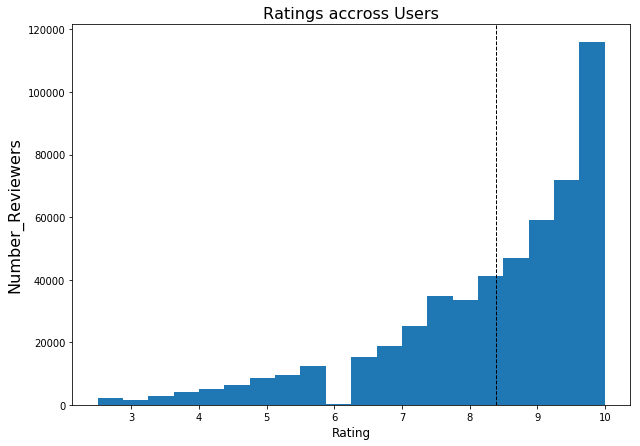

In [15]:
# Some plots of Ratings against Hotels and weekly ratings
from matplotlib import rcParams

plt.figure(figsize=(10,7))
plt.hist(df['Reviewer_Score'],bins=20)
plt.ylabel('Number_Reviewers',fontsize=16)
plt.xlabel('Rating',fontsize=12)
plt.title('Ratings accross Users',fontsize=16)
plt.axvline(df['Reviewer_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_user.png')

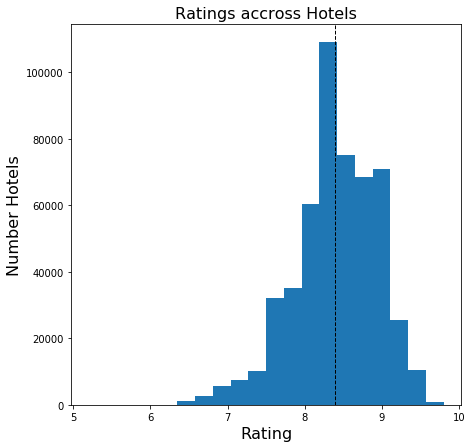

In [16]:
plt.figure(figsize=(7,7))
plt.hist(df['Average_Score'],bins=20)
plt.ylabel('Number Hotels',fontsize=16)
plt.xlabel('Rating',fontsize=16)
plt.title('Ratings accross Hotels',fontsize=16)
plt.axvline(df['Average_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_hotel.png')


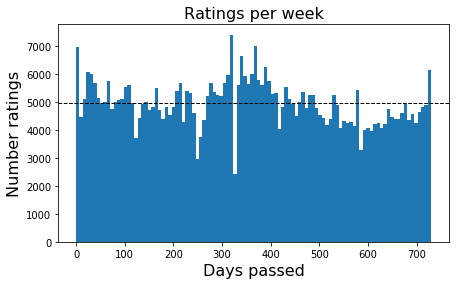

In [17]:
plt.figure(figsize=(7,4))
week_bins=int(np.floor((max(df['days_since_review'])-min(df['days_since_review']))/7))
vals = plt.hist(df['days_since_review'],bins=week_bins);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Days passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week.png')

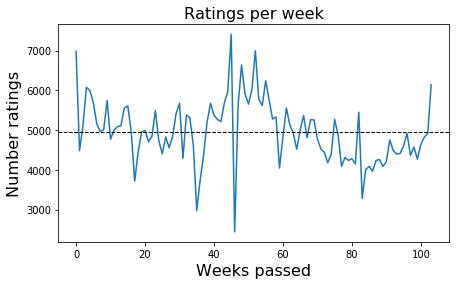

In [18]:
plt.figure(figsize=(7,4))
plt.plot(vals[0]);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Weeks passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week_plot.png')